# Часть 2: Языковые модели

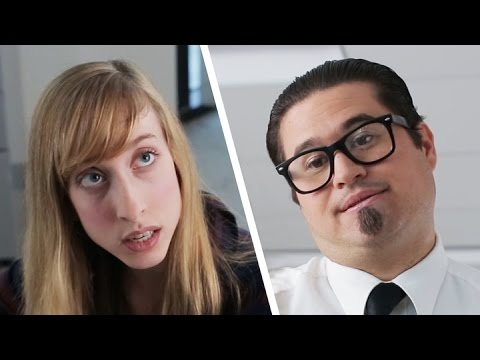

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('65GbpVZTgAk')

http://karpathy.github.io/2015/05/21/rnn-effectiveness/

# Марковские цепи и генеративное моделирование

До этого момента мы рассматривали только задачу делания каких-либо вывода по данным. Это скучно, и ML не только об этом. Во всех следующих занятиях мы будем в каком-то виде генерировать данные. Yay!

**Марковский процесс** — случайный процесс, эволюция которого на каждом шаге не зависит от предшествовавшей истории.

Естественный язык, музыку и всё такое можно тоже моделировать как марковский процесс, где состоянием будет всё уже сгенерированное. Языковые модели — это аппроксиматоры такого марковского процесса. Одним из способов её реализовать является рекуррентная сеть, обученная предсказывать следующий токен по всем предыдущим.

![markov](images/markov.png)

После примерно 20 эпох оно должно генерировать что-то адекватное. Лучше перенесите это на Colab, потому что 20 эпох это долго.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys

Using TensorFlow backend.


In [0]:
path = get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print(len(text))

581632/600901 [============================>.] - ETA: 0s600893


In [0]:
idx2char = sorted(list(set(text)))
char2idx = dict((c, i) for i, c in enumerate(chars))
print(len(idx2char)) # это сколько у нас будет токенов

57


In [0]:
maxlen = 50
step = 10
sentences = []
targets = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    targets.append(text[i + maxlen])
print(len(sentences)) # сколько у нас получилось сэмплов

60085


Вспоминаем, что Keras не любит что-либо не векторное. Сделаем one-hot encoding.

In [0]:
X = np.zeros((len(sentences), maxlen, len(idx2char)))
y = np.zeros((len(sentences), len(idx2char)))
for i, sentence in enumerate(sentences):
    for j, c in enumerate(sentence):
        X[i, j, char2idx[c]] = 1
    y[i, char2idx[targets[i]]] = 1

In [0]:
model = Sequential([
    LSTM(128, input_shape=(maxlen, len(idx2char))),
    Dense(len(chars), activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam')

Столько теории, обработки данных, а модель в итоге занимает 3 строчки. В этом вся суть NLP.

Перед тем, как её зафитить, напишем функцию, которая будет генерировать предложение, чтобы во время обучения смотреть, что она умеет.

In [0]:
    sampled = [char_to_idx[c] for c in header]
    for c in header[:-1]:
        batch = np.zeros((1, 1))
        batch[0, 0] = char_to_idx[c]
        model.predict_on_batch(batch)

    for i in range(num_chars):
        batch = np.zeros((1, 1))
        if sampled:
            batch[0, 0] = sampled[-1]
        else:
            batch[0, 0] = np.random.randint(vocab_size)
        result = model.predict_on_batch(batch).ravel()
        sample = np.random.choice(range(vocab_size), p=result)
        sampled.append(sample)
        
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Будем выводить сгенерированные предложения по ходу обучения. Осторожно, код вообще не тестирован, но идейно правильный.

In [0]:
for epoch in range(1, 20):
    print('Iteration', iteration)
    model.fit(X, y, batch_size=128, epochs=1)

    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    print(generated + '...')

    for i in range(100):
        data = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            data[0, t, char2idx[char]] = 1.

        preds = model.predict(data, verbose=0)[0]
        next_index = np.random.choice(range(len(preds)), p=preds)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char
    
    print(generated)

Языковые модели используются очень много где. Они являются центральной моделью NLP.

* Ими можно делать диалоговые системы: скармливаем предыдущее сообщение и генерируем следующее до токена остановки.
* Подсказки поиска в Google делаются примерно на них.
* Автокоррекцию и спеллчекинг можно сделать, находя «странные» токены.
* Их можно пихнуть в ансамбль для задачи перевода, например.
* Сжатие текстовых данных основано на языковых моделях (правда не нейросетевых, потому что они сами весят много). Есть способ сжимать данные эффективно, если мы знаем их распределение.

# Идеи улучшения

**Teacher forcing**. Можно делать лосс не один (предикт последнего символа), а много — мы же можем преобразовывать в распределение каждое из скрытых состояний и попыться предсказать следующие символы для них.

**Embedding**. Заменить one-hot сразу на эмбеддинг для эффективности вычислений.

**Токенизация**. Должно получиться намного лучше, если разбивать по словам или чему-то подобному.

**Предобученные ембеддинги**. Если использовать какую-то общеприменимую токенизацию, то на неё должны найтись хорошие вектора, которые можно использовать.

**Температура**. Можно попробовать перед тем, как прогонять последний слой через softmax, домножить их на какую-то константу. Если эта константа больше 1, то сгенерированный текст окажется более «правдоподобным», но скучным и однообразным, если меньше 1 — то наоборот. С температурой можно поэкспериментировать.